## 0. Requerimientos e importes

In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

## 1. Estructuracion de Datasets

Primero unimos las dos hojas que estan en el excel de calidad de trillado, de estas hojas solo tomamos algunas columnas para nuestro modelo.

In [3]:
excel_calidad = pd.read_excel(
    'CC_FT_17_Formato_de_Control_de_Calidad_Café_de_Trillado.xlsx',
    sheet_name = ['CONTROL CALIDAD CAFE TRILLADO J' , 'Sheet2'],
    skiprows=5,
    skipfooter=4
)

excel_calidad['CONTROL CALIDAD CAFE TRILLADO J'].columns = excel_calidad['CONTROL CALIDAD CAFE TRILLADO J'].columns.str.strip()
excel_calidad['Sheet2'].columns = excel_calidad['Sheet2'].columns.str.strip()
df_calidad = pd.concat(excel_calidad.values(), ignore_index=True)

df_calidad = df_calidad[[
    'LOTE', 'DENOMINACIÓN/     MARCA', 'CANTIDAD', '%H', 'MALLAS',
    'NOTAS DE CATACIÓN', 'PUNTAJE'
]]
df_calidad.dropna(subset=['LOTE'], inplace=True)
df_calidad.rename(columns={'DENOMINACIÓN/     MARCA': 'MARCA'}, inplace=True)

df_calidad

,LOTE,MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
2,01-190722,Madre Laura,765.00,10.9,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
3,09-190722,Tabi Natural,204.00,10.2,14,"Frutas maduras, nibs de cacao, acidez brillant...",85
4,10-190722,Don Mario,165.00,10.7,14,"Panela, durazno, miel, acidez brillante citric...",84.5
5,07-19-07-22,Don Felix,0.45,10.5,14,"Moras maduras, chocolate negro, acidez media c...",84.5
6,01-291022,Madre Laura,105.00,10.7,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
...,...,...,...,...,...,...,...
120,01-271023,Madre Laura,20.00,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
121,01-100124,Madre Laura,20.00,10.4,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
122,01-020424,Madre Laura,20.00,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
123,01-200624,Madre Laura,14.00,10.8,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84


Aca trabajamos sobre la columna de Marca, tenemos que en esta se guardan muchos adjetivos sobre el cafe, para tomarlos en cuenta sin saturar el modelo con variables vamos a agrupar estos adjetivos en 13 grupos.

Tambien empezamos a ver errores en los datos en forma de typos en esos adjetivos.

In [4]:
typos = {
    'fnal': 'final',
    'caramleo': 'caramelo',
    'cuepo': 'cuerpo',
    'balanaceado': 'balanceado'
}
typos_patron = r'\b(' + '|'.join(typos.keys()) + r')\b'

agr = {
    r'\b(arandanos|moras? maduras?|frambuesa|frutos rojos|fresas?|ciruela madura)\b':'bayas',
    r'\b(limon(?:aria|ciollo)?|mandarina|naranja|sandia|uva|durazno|manzana roja|frutas (?:amarillas|maduras))\b':'frutales',
    r'\bacidez\b.*':'acidez',
    r'\b(cuerpo\b.*|aterciopelado|cremoso(?: medio)?|sedoso)\b':'cuerpo',
    r'\b(cacao|nibs de cacao|chocolate(?: al \d+%|.*)?)\b':'chocolate',
    r'\b(dulce(?: de leche| prolongado| como la melaza)?|azucar morena|panela|melao de panela|miel(?: de maple)?)\b':'dulce',
    r'\b(jazmin|lavanda|rosas?|flor de naranja|final floral dulce)\b':'floral',
    r'\b(final(?: con notas a [\w\s]+)?|prolongado(?: a [\w\s]+)?)\b':'final',
    r'\b(clavos de olor|vainilla|nuez moscada|residual a cascara de mandarina)\b':'especias',
    r'\b(almendras|nueces?)\b':'nueces',
    r'\bresidual\b.*':'residual',
    r'\bjalea\b':'jalea',
    r'\b(cedro|te de cedron|menta)\b':'otros'
}

serie = (df_calidad.pop('NOTAS DE CATACIÓN')      # lo extraemos y quitamos del df
           .fillna('')
           .astype(str).str.lower()
           .str.replace(typos_patron, lambda m: typos[m.group(0)], regex=True)
)
for pat, cat in agr.items():
    serie = serie.str.replace(pat, f',{cat},', regex=True)

# limpieza de delimitadores en dos pasos
serie = (serie
    .str.replace(r'\s*[y,\.]+\s*', ',', regex=True)  # todo " y ", comas con espacios o puntos → ","
    .str.replace(r',+', ',',      regex=True)        # colapsa comas múltiples
    .str.strip(',')                                  # quita comas al inicio/fin
    .str.replace(r'\b(?:a)?\b', '', regex=True)      # elimina token "a" solitario
    .str.replace(r',+', ',',      regex=True)
    .str.strip(',')
)

# dummies + fusionar duplicados con un solo groupby
dummies = (
    serie.str.get_dummies(sep=',')
         .T.groupby(level=0).max()
         .T
)

# 4) montamos el df final
df_calidad = pd.concat([df_calidad, dummies], axis=1)

df_calidad

,LOTE,MARCA,CANTIDAD,%H,MALLAS,PUNTAJE,acidez,as,ba,caramelo,...,dulce,especias,flor de,floral,frutales,jalea,maracu,mora,nueces,otros
2,01-190722,Madre Laura,765.00,10.9,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,09-190722,Tabi Natural,204.00,10.2,14,85,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10-190722,Don Mario,165.00,10.7,14,84.5,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5,07-19-07-22,Don Felix,0.45,10.5,14,84.5,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6,01-291022,Madre Laura,105.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,01-271023,Madre Laura,20.00,10.5,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121,01-100124,Madre Laura,20.00,10.4,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,01-020424,Madre Laura,20.00,10.5,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,01-200624,Madre Laura,14.00,10.8,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
excel_tostion = pd.read_excel(
    'CC_FT_18_Formato_de_Tostión.xlsx',
    sheet_name=['TOSTIÓN JERICÓ L', 'TOSTIÓN JERICÓ'],
    skiprows=5,
    skipfooter=0
)

df_tostion = pd.concat(excel_tostion.values(), ignore_index=True)
df_tostion.columns = df_tostion.columns.str.strip()
df_tostion = df_tostion.drop(columns=['Fecha', 'Observaciones','Tostador'])

df_tostion

,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste
0,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00
1,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00
2,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00
3,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00
4,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00
...,...,...,...,...,...,...,...,...,...,...,...
524,01-271023,Jerico,Colombia,Tradicional,Lavado,15.60,15.705128,13.15,Filtrado,180°-190°,9.36
525,01-100124,Jerico,Colombia,Tradicional,Lavado,15.00,13.333333,13.00,Filtrado,180°-190°,9.32
526,01-020424,Jerico,Colombia,Tradicional,Lavado,14.50,16.551724,12.10,Filtrado,180°-190°,9.36
527,01-200624,Jerico,Colombia,Tradicional,lavado,10.70,13.551402,9.25,Filtrado,180°-190°,9.28


Se unen los datos de tostion con los de trillado, hacemos el merge usando las columnas de lote como llaves principales. Tenemos que despues de esta union hay muchos typos en los datos de varias columnas de Tostion, se limpian y se cambia el formato de dato en unas columnas numericas.

In [6]:
df =  pd.merge(df_calidad, df_tostion, left_on='LOTE', right_on='Lote', how='inner') \
    .drop(columns=["Lote"])

tostion_typos = {
    'Beneficio': {
        'lavado': 'Lavado',
        'Lavado ': 'Lavado',
        'lavado ': 'Lavado',
    },
    'Perfil': {
        'Expressso': 'Espresso',
        'Expresso': 'Espresso',
        'Espresso': 'Espresso',
        'Espressso' : 'Espresso',
        'Espresso ': 'Espresso',
        'Filtrados': 'Filtrado',
        'Filtrado ': 'Filtrado',
        'Filtrados ' : 'Filtrado',
    },
    'Origen': {
        'Herrra ': 'Herrera',
        'Herrerra': 'Herrera',
        'Herrera ': 'Herrera',
        'Jerico ': 'Jerico',
        'Jericó ': 'Jerico'
    },
    'Proceso': {
        'Tradicional': 'Tradicional',
        'Tradicional ': 'Tradicional',
        'tradicional ' : 'Tradicional'
    },
    'Variedad': { 'Caturra ': 'Caturra' }
}
for columna, cambios in tostion_typos.items():
    df[columna] = df[columna].replace(cambios)

df[['Temp_inicio', 'Temp_final']] = df['Temp. De inicio y final'].str.extract(r'(\d+)[°º]*/(\d+)[°º]*').astype(float)
df['Tiempo de tueste'] = pd.to_datetime(
    df['Tiempo de tueste'],
    format='%H:%M:%S',
    errors='coerce'
)

df['%H'] = pd.to_numeric(df['%H'], errors='coerce')
df['PUNTAJE'] = pd.to_numeric(df['PUNTAJE'], errors='coerce')
df['MALLAS'] = pd.to_numeric(df['MALLAS'], errors='coerce')

df['Tiempo de tueste'] = (
    df['Tiempo de tueste'].dt.hour * 60 +
    df['Tiempo de tueste'].dt.minute +
    df['Tiempo de tueste'].dt.second / 60
)

imp = ['%H', 'Tiempo de tueste', 'Temp_inicio', 'Temp_final']
for im in imp:
    df[im] = df[im].fillna(df[im].mean())

df

,LOTE,MARCA,CANTIDAD,%H,MALLAS,PUNTAJE,acidez,as,ba,caramelo,...,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Temp_inicio,Temp_final
0,01-190722,Madre Laura,765.0,10.9,14,84.0,0,0,0,0,...,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,481.000000,175.000000,191.000000
1,01-190722,Madre Laura,765.0,10.9,14,84.0,0,0,0,0,...,Tradicional,Lavado,3.00,16.666667,2.50,Espresso,175°/195°,522.000000,175.000000,195.000000
2,01-190722,Madre Laura,765.0,10.9,14,84.0,0,0,0,0,...,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,478.000000,175.000000,190.000000
3,01-190722,Madre Laura,765.0,10.9,14,84.0,0,0,0,0,...,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,482.000000,175.000000,191.000000
4,01-190722,Madre Laura,765.0,10.9,14,84.0,0,0,0,0,...,Tradicional,Lavado,29.00,15.344828,24.55,Filtrado,175°/192°,482.000000,175.000000,192.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,01-271023,Madre Laura,20.0,10.5,14,84.0,0,0,0,0,...,Tradicional,Lavado,15.60,15.705128,13.15,Filtrado,180°-190°,489.108597,173.747126,191.714943
465,01-100124,Madre Laura,20.0,10.4,14,84.0,0,0,0,0,...,Tradicional,Lavado,15.00,13.333333,13.00,Filtrado,180°-190°,489.108597,173.747126,191.714943
466,01-020424,Madre Laura,20.0,10.5,14,84.0,0,0,0,0,...,Tradicional,Lavado,14.50,16.551724,12.10,Filtrado,180°-190°,489.108597,173.747126,191.714943
467,01-200624,Madre Laura,14.0,10.8,14,84.0,0,0,0,0,...,Tradicional,Lavado,10.70,13.551402,9.25,Filtrado,180°-190°,489.108597,173.747126,191.714943


Ahora creamos las variables necesarias para el modelo de regresion, tomando la columna de Puntaje como nuestro objetivo.

Usamos el encoder de OneHot de la misma forma que creamos nuevas columnas para los adjetivos del cafe, queremos una manera de usar estas variables categoricas en el modelo. Por otro lado, tenemos un pipeline para la columna de Puntaje, y es que hay casos en los que para un conjunto de datos no hay un puntaje establecido, en estos casos vamos a usar la media de los Puntajes.

In [7]:
Y = df['PUNTAJE']
X = df.drop(columns=['LOTE', 'PUNTAJE', 'Temp. De inicio y final'])

X_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

X_trans = X_pipeline.fit_transform(
    X.select_dtypes(include=['object'])
)

X = pd.concat([
    X.select_dtypes(exclude=['object']),
    pd.DataFrame(X_trans, columns=X_pipeline.get_feature_names_out())
], axis=1)

Y_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
Y = Y_pipeline.fit_transform(Y.values.reshape(-1, 1)).ravel()

df_train, df_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X

,CANTIDAD,%H,MALLAS,acidez,as,ba,caramelo,caña de azucar,cereza,chocolate,...,Proceso_Honey,Proceso_Lavado,Proceso_Natural,Proceso_Tradicional,Beneficio_Descafeinado,Beneficio_Honey,Beneficio_Lavado,Beneficio_Natural,Perfil_Espresso,Perfil_Filtrado
0,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,20.0,10.5,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
465,20.0,10.4,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
466,20.0,10.5,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
467,14.0,10.8,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## Modelo 1: Support Vector Regression

In [8]:
modelo_svr = Pipeline([
    # Escalamos todas las variables numéricas
    ('scaler', StandardScaler()),
    # SVR con kernel RBF, C moderado, gamma automático, epsilon por defecto
    ('svr', SVR(
        kernel='rbf',    # más estable que poly para pocos datos
        C=1.0,           # mayor regularización (menos overfitting)
        gamma='scale',   # γ = 1 / (n_features * X.var())
        epsilon=0.1,      # default, tolerancia del tubo ε
        degree=3
    ))
])

modelo_svr.fit(df_train, y_train)

# 4. Evalúa en test
r2 = modelo_svr.score(df_test, y_test)
print(f"R² en test: {r2:.3f}")

cv_scores = cross_val_score(
    modelo_svr,  # o full_pipeline, tu objeto Pipeline completo
    X,                    # aquí entra todo tu DataFrame X sin transformar
    Y,                    # la variable objetivo
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1             # opcional: paraleliza en todos los núcleos
)

# cross_val_score devuelve MSE negativos, invierte el signo:
cv_mse = -cv_scores.mean()

print(f"Error cuadrático medio (MSE) en validación cruzada: {cv_mse:.4f}")
print(f"Desviación estándar de MSE en CV: {cv_scores.std():.4f}")

R² en test: 0.989
Error cuadrático medio (MSE) en validación cruzada: 0.2944
Desviación estándar de MSE en CV: 0.3462


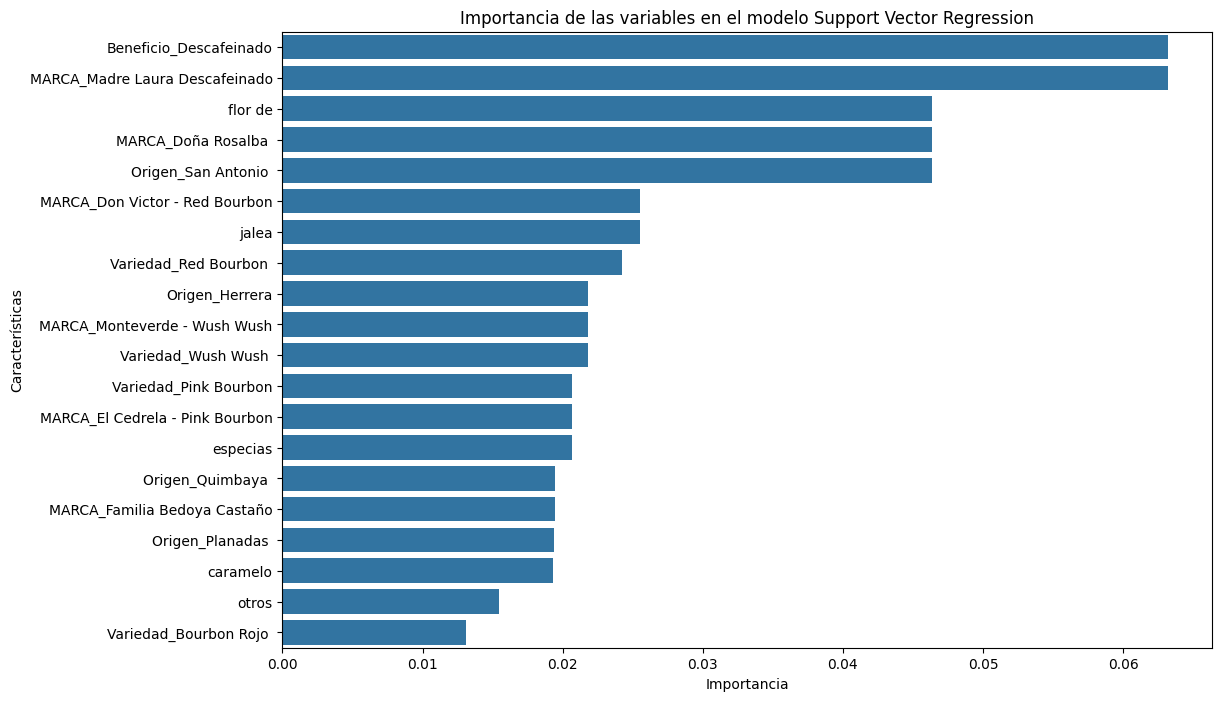

In [9]:
results = permutation_importance(
    modelo_svr,  # tu Pipeline con scaler+svr
    df_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_df = (
  pd.DataFrame({
    'Feature': X.columns,
    'Importance': results.importances_mean
  })
  .sort_values('Importance', ascending=False)
)

# Visualizamos las importancias de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(20))
plt.title('Importancia de las variables en el modelo Support Vector Regression')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

## Modelo 2: Bayesian ridge regression

In [10]:
bayes_pipeline = Pipeline([
    ('scaler', StandardScaler()),        # normaliza cada feature a media 0, varianza 1
    ('bayes',  BayesianRidge())          # regresión bayesiana
])

# 3. Define la malla de hiperparámetros
param_grid = {
    'bayes__alpha_1':  [1e-6, 1e-5, 1e-4],
    'bayes__alpha_2':  [1e-6, 1e-5, 1e-4],
    'bayes__lambda_1': [1e-6, 1e-5, 1e-4],
    'bayes__lambda_2': [1e-6, 1e-5, 1e-4]
}

# 4. Configura GridSearchCV
grid = GridSearchCV(
    estimator=bayes_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 5. Ejecuta la búsqueda
grid.fit(df_train, y_train)

# 6. Resultados
print("Mejores parámetros:", grid.best_params_)
best_mse = -grid.best_score_
print(f"MSE medio CV (5-fold) con mejores parámetros: {best_mse:.4f}")

# 7. Evalúa en el test set
y_pred_test = grid.best_estimator_.predict(df_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"MSE en test set: {mse_test:.4f}")

# 8. Cross-validation externa sobre todo el dataset con el mejor estimador
cv_scores = cross_val_score(
    grid.best_estimator_,  # pipeline ya ajustado con los mejores parámetros
    X, Y,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
mse_cv_external = -cv_scores.mean()
std_cv_external = cv_scores.std()
print(f"MSE medio (5-fold CV externa): {mse_cv_external:.4f} ± {std_cv_external:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros: {'bayes__alpha_1': 1e-06, 'bayes__alpha_2': 0.0001, 'bayes__lambda_1': 0.0001, 'bayes__lambda_2': 1e-06}
MSE medio CV (5-fold) con mejores parámetros: 0.0062
MSE en test set: 0.0035
MSE medio (5-fold CV externa): 0.2457 ± 0.3832


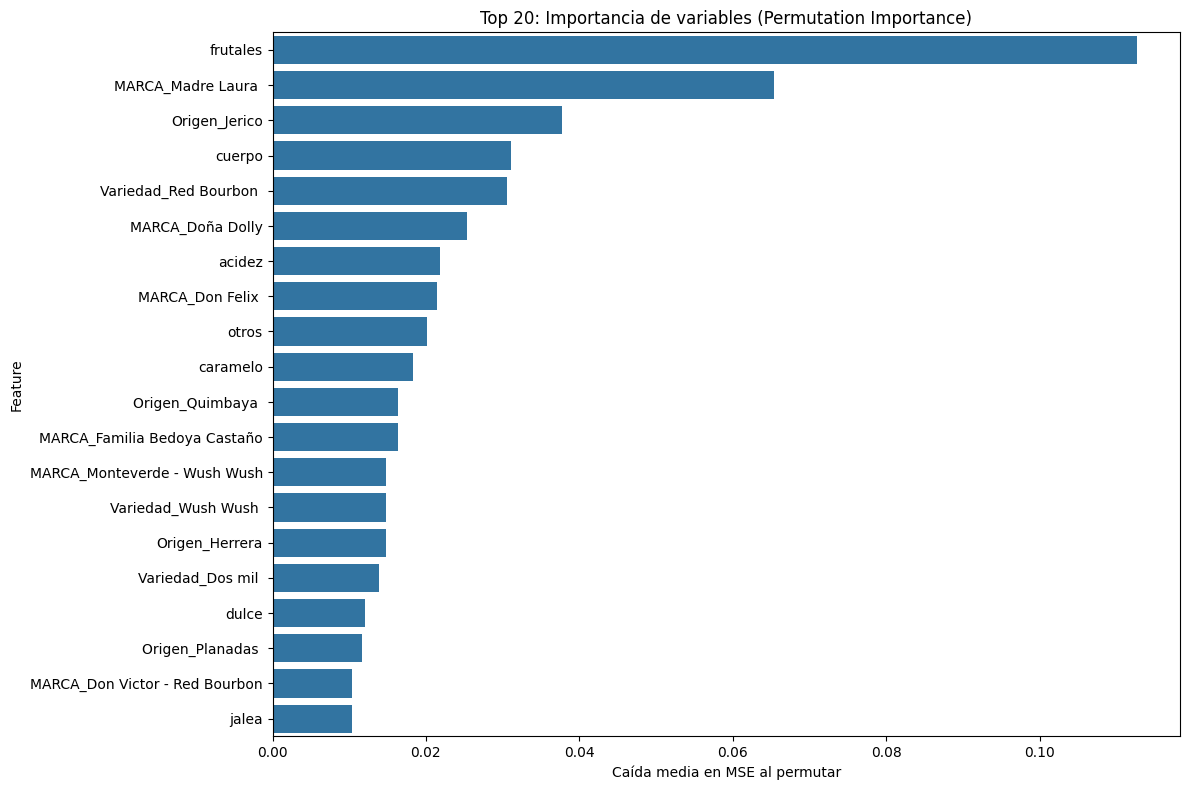

In [11]:
results = permutation_importance(
    grid.best_estimator_,       # o modelo_svr si es tu pipeline final
    df_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# 2) Monta el DataFrame de importancias
imp_df = (
    pd.DataFrame({
        'Feature': df_test.columns,               # nombres de tus variables
        'Importance': results.importances_mean    # media de las caídas en la métrica
    })
    .sort_values('Importance', ascending=False)    # orden descendente
)

# 3) Grafica las top-20 variables
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=imp_df.head(20),   # las 20 más importantes
    orient='h'
)
plt.title('Top 20: Importancia de variables (Permutation Importance)')
plt.xlabel('Caída media en MSE al permutar')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()